# WAV separation

<div class="alert alert-info">

This tutorial is available as an IPython notebook at [malaya-speech/example/multispeaker-separation-wav](https://github.com/huseinzol05/malaya-speech/tree/master/example/multispeaker-separation-wav).
    
</div>

<div class="alert alert-info">

This module is language independent, so it save to use on different languages.
    
</div>

In [1]:
import malaya_speech
import numpy as np
from malaya_speech import Pipeline
import matplotlib.pyplot as plt
import IPython.display as ipd

### Multispeaker separation description

1. FastSep-WAV only able to separate 8k sample rate.
2. FastSep-WAV trained to separate 4 unique speakers.
3. Trained on VCTK, Nepali, Mandarin and Malay mixed speakers.

### List available FastSep-WAV

In [2]:
malaya_speech.multispeaker_separation.available_deep_wav()

INFO:root:Tested on 1k samples


,Size (MB),Quantized Size (MB),SISNR PIT
fastsep-2,78.7,20.5,14.156882
fastsep-4,155.0,40.2,19.682500


### Load model

```python
def deep_wav(model: str = 'fastsep-4', quantized: bool = False, **kwargs):
    """
    Load FastSep model, trained on raw 8k wav using SISNR PIT loss.

    Parameters
    ----------
    model : str, optional (default='fastsep-4')
        Model architecture supported. Allowed values:

        * ``'fastsep-4'`` - FastSep 4 layers trained on raw 8k wav.
        * ``'fastsep-2'`` - FastSep 2 layers trained on raw 8k wav.
    quantized : bool, optional (default=False)
        if True, will load 8-bit quantized model. 
        Quantized model not necessary faster, totally depends on the machine.

    Returns
    -------
    result : malaya_speech.model.tf.Split class
    """
```

In [3]:
model = malaya_speech.multispeaker_separation.deep_wav('fastsep-4')

### Load quantized model

In [4]:
quantized_model = malaya_speech.multispeaker_separation.deep_wav('fastsep-4', quantized = True)

### Generate random mixed audio

In [5]:
import random
import malaya_speech.augmentation.waveform as augmentation

sr = 8000
speakers_size = 4

def read_wav(f):
    return malaya_speech.load(f, sr = sr)


def random_sampling(s, length):
    return augmentation.random_sampling(s, sr = sr, length = length)

def combine_speakers(files, n = 5, limit = 4):
    w_samples = random.sample(files, n)
    w_samples = [read_wav(f)[0] for f in w_samples]
    w_lens = [len(w) / sr for w in w_samples]
    w_lens = int(min(min(w_lens) * 1000, random.randint(3000, 7000)))
    w_samples = [random_sampling(w, length = w_lens) for w in w_samples]
    y = [w_samples[0]]
    left = w_samples[0].copy()

    combined = None

    for i in range(1, n):
        right = w_samples[i].copy()
        overlap = random.uniform(0.98, 1.0)
        len_overlap = int(overlap * len(right))
        minus = len(left) - len_overlap
        if minus < 0:
            minus = 0
        padded_right = np.pad(right, (minus, 0))
        left = np.pad(left, (0, len(padded_right) - len(left)))

        left = left + padded_right

        if i >= (limit - 1):
            if combined is None:
                combined = padded_right
            else:
                combined = np.pad(
                    combined, (0, len(padded_right) - len(combined))
                )
                combined += padded_right

        else:
            y.append(padded_right)

    if combined is not None:
        y.append(combined)
        
    maxs = [max(left)]
    for i in range(len(y)):
        if len(y[i]) != len(left):
            y[i] = np.pad(y[i], (0, len(left) - len(y[i])))
            maxs.append(max(y[i]))
            
    max_amp = max(maxs)
    mix_scaling = 1 / max_amp * 0.9
    left = left * mix_scaling
    
    for i in range(len(y)):
        y[i] = y[i] * mix_scaling
        
    return left, y

In [6]:
from glob import glob

wavs = glob('speech/example-speaker/*.wav')
wavs.extend(glob('speech/vctk/*.flac'))
len(wavs)

23

In [18]:
left, y = combine_speakers(wavs, speakers_size)
len(left) / sr, len(y)

(3.45525, 4)

In [19]:
ipd.Audio(left, rate = sr)

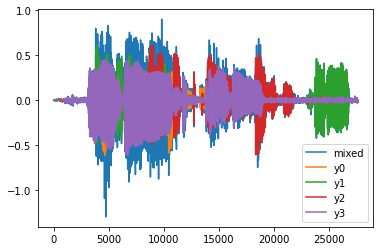

In [20]:
plt.plot(left, label = 'mixed')
plt.plot(y[0], label = 'y0')
plt.plot(y[1], label = 'y1')
plt.plot(y[2], label = 'y2')
plt.plot(y[3], label = 'y3')
plt.legend()
plt.show()

### Predict

```python
def predict(self, input):
    """
    Split an audio into 4 different speakers.

    Parameters
    ----------
    input: np.array or malaya_speech.model.frame.Frame

    Returns
    -------
    result: np.array
    """
```

In [21]:
%%time

y = model.predict(left)
y.shape

CPU times: user 20.5 s, sys: 1.68 s, total: 22.2 s
Wall time: 3.51 s


(4, 27642)

In [22]:
%%time

quantized_y = quantized_model.predict(left)
quantized_y.shape

CPU times: user 20.8 s, sys: 1.73 s, total: 22.5 s
Wall time: 3.45 s


(4, 27642)

### Results

In [23]:
ipd.Audio(y[0], rate = sr)

In [24]:
ipd.Audio(y[1], rate = sr)

In [25]:
ipd.Audio(y[2], rate = sr)

In [26]:
ipd.Audio(y[3], rate = sr)

### Quantized results

In [27]:
ipd.Audio(quantized_y[0], rate = sr)

In [28]:
ipd.Audio(quantized_y[1], rate = sr)

In [29]:
ipd.Audio(quantized_y[2], rate = sr)

In [30]:
ipd.Audio(quantized_y[3], rate = sr)